In [2]:
import pandas as pd
import numpy as np

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
df = pd.read_csv("Loan_default.csv")  # apni file ka exact naam check kar lena

print(df.shape)
print(df.head())
print(df.columns)


(255347, 18)
       LoanID  Age  Income  LoanAmount  CreditScore  MonthsEmployed  \
0  I38PQUQS96   56   85994       50587          520              80   
1  HPSK72WA7R   69   50432      124440          458              15   
2  C1OZ6DPJ8Y   46   84208      129188          451              26   
3  V2KKSFM3UN   32   31713       44799          743               0   
4  EY08JDHTZP   60   20437        9139          633               8   

   NumCreditLines  InterestRate  LoanTerm  DTIRatio    Education  \
0               4         15.23        36      0.44   Bachelor's   
1               1          4.81        60      0.68     Master's   
2               3         21.17        24      0.31     Master's   
3               3          7.07        24      0.23  High School   
4               4          6.51        48      0.73   Bachelor's   

  EmploymentType MaritalStatus HasMortgage HasDependents LoanPurpose  \
0      Full-time      Divorced         Yes           Yes       Other   
1      

In [6]:
df.columns = df.columns.str.strip()


In [8]:
for col in df.columns:
    if df[col].nunique() == 2:
        print(col)


HasMortgage
HasDependents
HasCoSigner
Default


In [10]:
y = df['Default']
X = df.drop('Default', axis=1)


In [12]:
# Numeric columns
num_cols = X.select_dtypes(include=np.number).columns
X[num_cols] = X[num_cols].fillna(X[num_cols].median())

# Categorical columns
cat_cols = X.select_dtypes(include='object').columns
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0])


C:\Users\hp 820\AppData\Local\Temp\ipykernel_3784\3544018916.py:6: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  cat_cols = X.select_dtypes(include='object').columns


In [14]:
le = LabelEncoder()

for col in cat_cols:
    X[col] = le.fit_transform(X[col])


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [18]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [20]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, y_train)

# Probability predictions
y_prob = model.predict_proba(X_test_scaled)[:,1]


In [22]:
y_pred = (y_prob >= 0.5).astype(int)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


[[45020   119]
 [ 5748   183]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     45139
           1       0.61      0.03      0.06      5931

    accuracy                           0.89     51070
   macro avg       0.75      0.51      0.50     51070
weighted avg       0.85      0.89      0.84     51070

ROC-AUC: 0.7497223744431618


In [24]:
thresholds = np.arange(0.0, 1.0, 0.01)

best_cost = float('inf')
best_threshold = 0.5

for t in thresholds:
    
    y_pred_t = (y_prob >= t).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    
    cost = fp * 10000 + fn * 1000
    
    if cost < best_cost:
        best_cost = cost
        best_threshold = t

print("Best Threshold:", best_threshold)
print("Minimum Business Cost:", best_cost)


Best Threshold: 0.75
Minimum Business Cost: 5931000


In [26]:
y_final = (y_prob >= best_threshold).astype(int)

print(confusion_matrix(y_test, y_final))
print(classification_report(y_test, y_final))


[[45139     0]
 [ 5931     0]]
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     45139
           1       0.00      0.00      0.00      5931

    accuracy                           0.88     51070
   macro avg       0.44      0.50      0.47     51070
weighted avg       0.78      0.88      0.83     51070



E:\software\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\software\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
E:\software\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [28]:
importance = pd.Series(model.coef_[0], index=X.columns)
importance = importance.sort_values(ascending=False)

print(importance.head(10))


InterestRate      0.457028
LoanAmount        0.299450
EmploymentType    0.144009
NumCreditLines    0.099817
DTIRatio          0.068046
LoanTerm          0.003636
LoanID           -0.004809
MaritalStatus    -0.025990
LoanPurpose      -0.036540
HasMortgage      -0.077733
dtype: float64


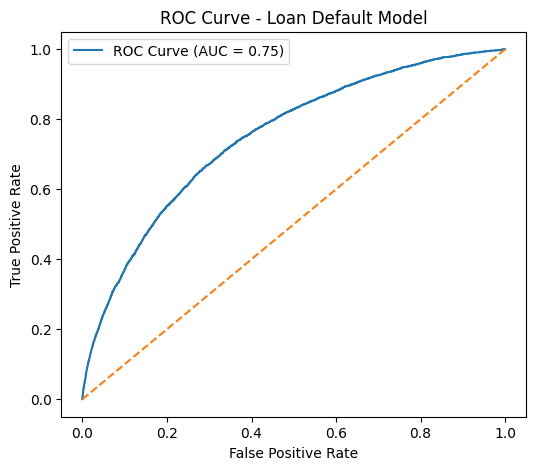

In [30]:
from sklearn.metrics import roc_curve, auc

# ROC values
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label="ROC Curve (AUC = %0.2f)" % roc_auc)
plt.plot([0,1], [0,1], linestyle='--')  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Loan Default Model")
plt.legend()
plt.show()


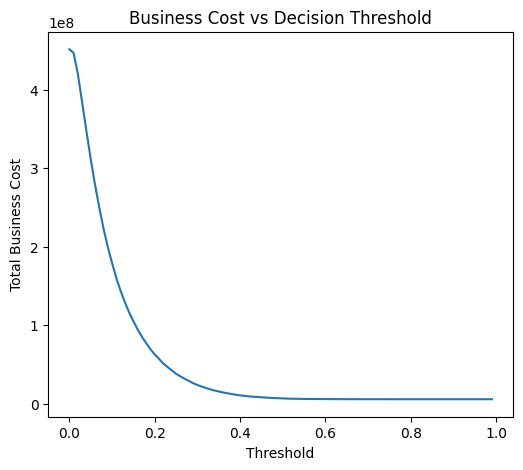

In [32]:
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

for t in thresholds:
    y_pred_t = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_t).ravel()
    cost = fp * 10000 + fn * 1000
    costs.append(cost)

# Plot
plt.figure(figsize=(6,5))
plt.plot(thresholds, costs)
plt.xlabel("Threshold")
plt.ylabel("Total Business Cost")
plt.title("Business Cost vs Decision Threshold")
plt.show()


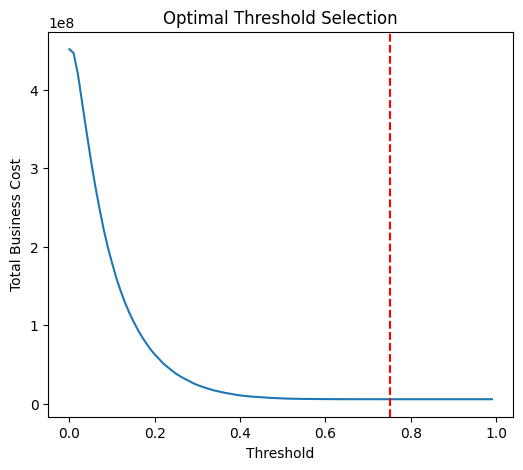

In [34]:
plt.figure(figsize=(6,5))
plt.plot(thresholds, costs)
plt.axvline(best_threshold, color='r', linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Total Business Cost")
plt.title("Optimal Threshold Selection")
plt.show()


- The default threshold (0.5) was not optimal for business.
- Adjusting threshold reduced financial loss significantly.
- Cost-based evaluation provides more realistic decision-making than accuracy.
